<a href="https://colab.research.google.com/github/ancastillar/Transformers-Create-your-own-poem-/blob/main/EDA_Create_your_own_poem!_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [2]:
!pip install aitextgen
!pip install flask-ngrok
!pip install flask==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 572 kB 13.0 MB/s 
     |████████████████████████████████| 4.4 MB 37.8 MB/s 
     |████████████████████████████████| 87 kB 6.2 MB/s 
     |████████████████████████████████| 585 kB 45.3 MB/s 
     |████████████████████████████████| 419 kB 45.7 MB/s 
     |████████████████████████████████| 140 kB 54.7 MB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
     |████████████████████████████████| 1.1 MB 38.7 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 271 kB 54.1 MB/s 
     |████████████████████████████████| 144 kB 50.5 MB/s 
  Created wheel for aitextgen: filename=aitextgen-0.5.2-py3-none-any.whl size=575905 sha256=1b38fdf97a14caab4757eb7e18011f33f12cf40f5651bbbf20f52dd9cf7

In [3]:
import pandas as pd
import numpy as np

#Text preprocessing
import string
import regex as re
import nltk
import unicodedata
nltk.download("popular") 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(rc = {'figure.figsize':(35,10)})
sns.set_palette("Paired")
sns.set_style("white")


##########Models
from aitextgen import aitextgen
import torch
import sys
import os
import random

from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Available GPUs: ", torch.cuda.get_device_name(current_device))
    print()

!nvidia-smi


import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



##Global Functions

In [4]:
def plot_word_cloud(df, name_poet_):
    
        print(name_poet)
        poems_selected = df[df["Poet"]==name_poet_]
        text = ["".join(x) for x in list(poems_selected["poem_clean"])]

        wordcloud = WordCloud(
            width = 3000,
            height = 2000,
            colormap = 'plasma',
            stopwords = stop_words +["like", "thee","thy", "thro","one","thou", "opon", "tis","u"], 
            background_color = 'white').generate(str(text))


        fig = plt.figure(
            figsize = (20, 10),
            facecolor = 'k',
            edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.show()


#################################################################################################################


##Functions for clean and normalize the data 
##########################################################################################################################################

def accent_remove(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s
    
    
##Remove simbols------------------------------------------------------------------------------------------------------------------------

def remove_simbols(x):
   emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           
                           "]+", flags=re.UNICODE)
   return emoji_pattern.sub(r'', x)

# General Cleaning--------------------------------------------------------------------------------------------------------------------

def clean_text(text):
   

    text = re.sub('\[.*?\!]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”?¿…,#&¡]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub(r'[^\x00-\x7F]',' ', text) #Remove all ascci codes
    text= re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', text)
    text = re.sub(r"^\s+",  " ", text)
    
    return text


## Import Data

In [25]:
df_poems_poe = pd.read_csv("/content/drive/MyDrive/proyecto_NLP/data/poe_poems_stanzas.csv")
df_poems = pd.read_csv("/content/drive/MyDrive/proyecto_NLP/data/PoetryFoundationData.csv")
df_poems_poe = df_poems_poe.rename(columns={"title": "Poet", "stanza_text":"Poem"})
df_poems_poe["Poet"] ="Poe"
df_poems = pd.concat([df_poems, df_poems_poe], axis=0)
df_poems = df_poems[["Poet","Poem"]]

print("Dimension of datase:", df_poems.shape)


Dimension of datase: (14069, 2)


##DataSet General Description

In [ ]:
df_poems.describe()

Poet          Poem
count                 13854         13854
unique                 3128         13754
top     William Shakespeare  \r\r\n\r\r\n
freq                     85            77

In [ ]:
df_poems["Poet"].value_counts()[0:200].plot(kind="bar")
plt.title("Distribution of the Top 200 of Poets in the corpus")
plt.xlabel("Poet Name")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

## DataSet Basic preprocessing

In [26]:
df_poems["Poem"] = df_poems["Poem"].apply(lambda x: x.lower())

####Run text cleaning

df_poems["poem_clean"] = df_poems["Poem"].apply(lambda x: accent_remove(x))

df_poems["poem_clean"] = df_poems["poem_clean"].apply(lambda x: remove_simbols(x) )

df_poems["poem_clean"] = df_poems["poem_clean"].apply(lambda x:  clean_text(x) )


df_poems["poem_clean"] = df_poems["poem_clean"].apply(lambda x: x.strip()) 

#####Drop possible duplicates

df_poems = df_poems.drop_duplicates("poem_clean")

In [27]:
df_poems.head(20)

Poet                                               Poem  \
0      Michelle Menting  \r\r\ndog bone, stapler,\r\r\ncribbage board, ...   
1         Lucia Cherciu  \r\r\nthe old cupola glinted above the clouds,...   
2            Ted Kooser  \r\r\nlook for me under the hood\r\r\nof that ...   
3       Grace Cavalieri  \r\r\nbehind the silo, the mother rabbit\r\r\n...   
4          Connie Wanek  \r\r\nwhen i push your button\r\r\nyou fly off...   
5   January Gill O'Neil  \r\r\nyou are the start of the week\r\r\nor th...   
6             Joy Harjo  \r\r\ninvisible fish swim this ghost ocean now...   
7             Joy Harjo  \r\r\ndon’t bother the earth spirit who lives ...   
8          John Ashbery  \r\r\nis anything central?\r\r\norchards flung...   
9          Simone White  \r\r\nhour in which i consider hydrangea, a sa...   
10      Heid E. Erdrich  \r\r\nshe couldn't help but sting my finger,\r...   
11          Sarah White  \r\r\ni will not speak ill of jack flick.\r\r\...   
12        Judith Harris  \r\r\nhow quiet is the spruce,\r\r\nthe wind t...   
13        Kelly Madigan  \r\r\nyou think we are the pointed argument,\r...   
14     Cathryn Essinger  \r\r\ni planted an apple tree in memory\r\r\no...   
15        P. Ivan Young  \r\r\nthe entrance at the back of the complex\...   
16          Truong Tran  \r\r\nmy father’s body is a map\r\r\na record ...   
17          Truong Tran  \r\r\nit has long been forgotten this practice...   
18        Debora Greger  \r\r\nwhy are you still seventeen\r\r\nand dri...   
19        Debora Greger  \r\r\n\r\r\n\r\r\n\r\r\nyes, your childhood no...   

                                           poem_clean  
0   dog bone stapler   cribbage board garlic press...  
1   the old cupola glinted above the clouds shone ...  
2   look for me under the hood   of that old chevr...  
3   behind the silo the mother rabbit   hunches li...  
4   when i push your button   you fly off the hand...  
5   you are the start of the week   or the end of ...  
6   invisible fish swim this ghost ocean now descr...  
7   dont bother the earth spirit who lives here sh...  
8   is anything central   orchards flung out on th...  
9   hour in which i consider hydrangea a salt or s...  
10  she couldnt help but sting my finger   clingin...  
11  i will not speak ill of jack flick   i will ra...  
12  how quiet is the spruce   the wind twills   th...  
13  you think we are the pointed argument   the ma...  
14  i planted an apple tree in memory   of my moth...  
15  the entrance at the back of the complex   led ...  
16  my fathers body is a map   a record of his jou...  
17  it has long been forgotten this practice of th...  
18  why are you still seventeen   and drifting lik...  
19  yes your childhood now a legend of fountains  ...

##  Some Visualizations: Word Cloud for top 10 Poets

In [ ]:
df_poems["Poet"].value_counts()[0:10]

William Shakespeare      85
Alfred, Lord Tennyson    73
William Wordsworth       51
Emily Dickinson          51
Rae Armantrout           49
John Ashbery             42
Yusef Komunyakaa         42
William Butler Yeats     41
John Donne               38
Walt Whitman             35
Name: Poet, dtype: int64

###Poet: Edgar Allan Poe

Poe


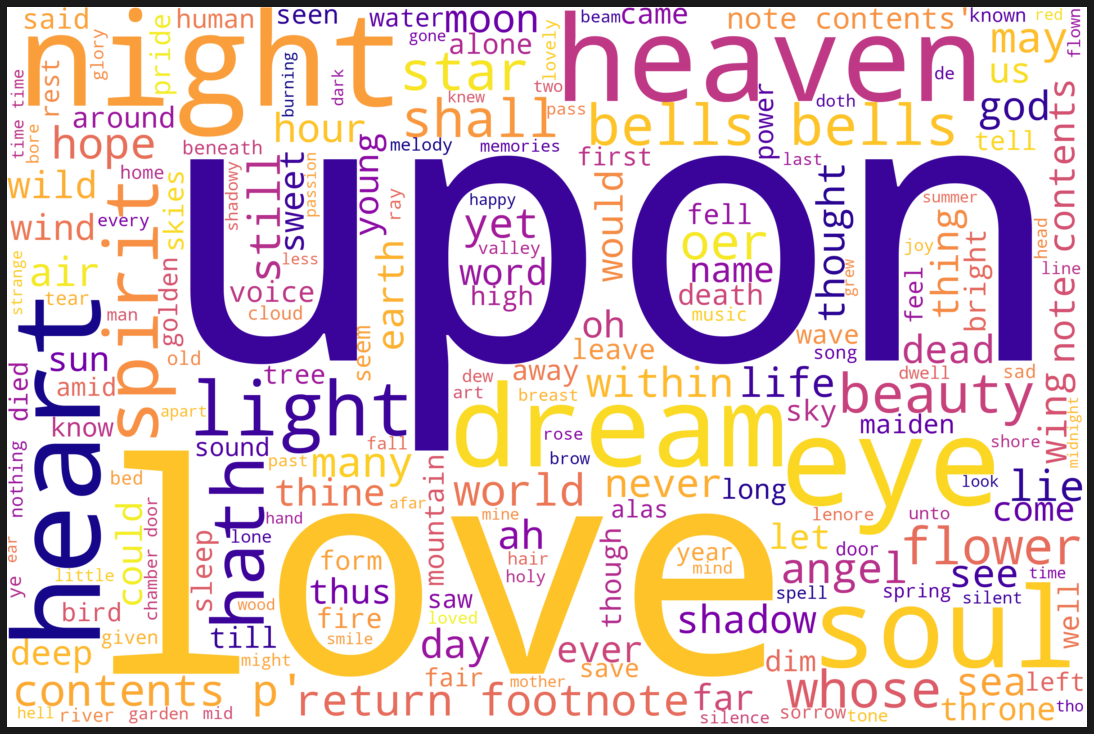

In [28]:
name_poet = "Poe"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

#### Poet: Willian Shakespeare

William Shakespeare


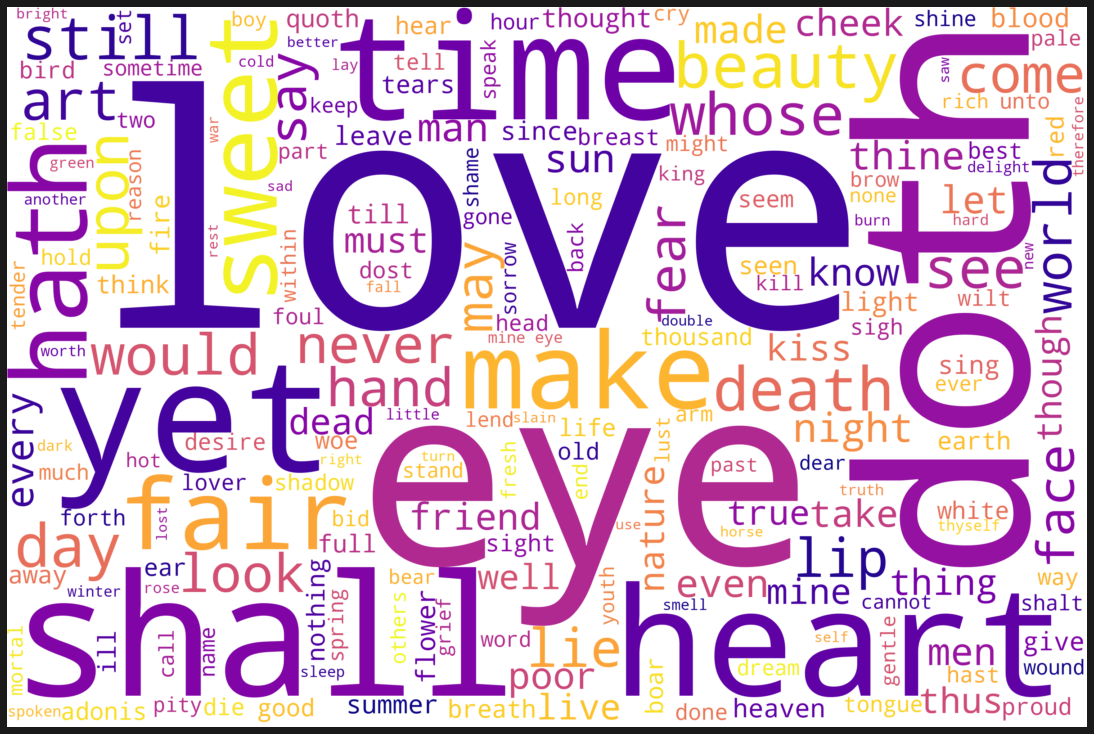

In [ ]:
name_poet = "William Shakespeare"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

#### Poet: Alfred, Lord Tennyson

In [ ]:
name_poet = "Alfred, Lord Tennyson"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

Alfred, Lord Tennyson


####Poet: William Wordsworth

William Wordsworth


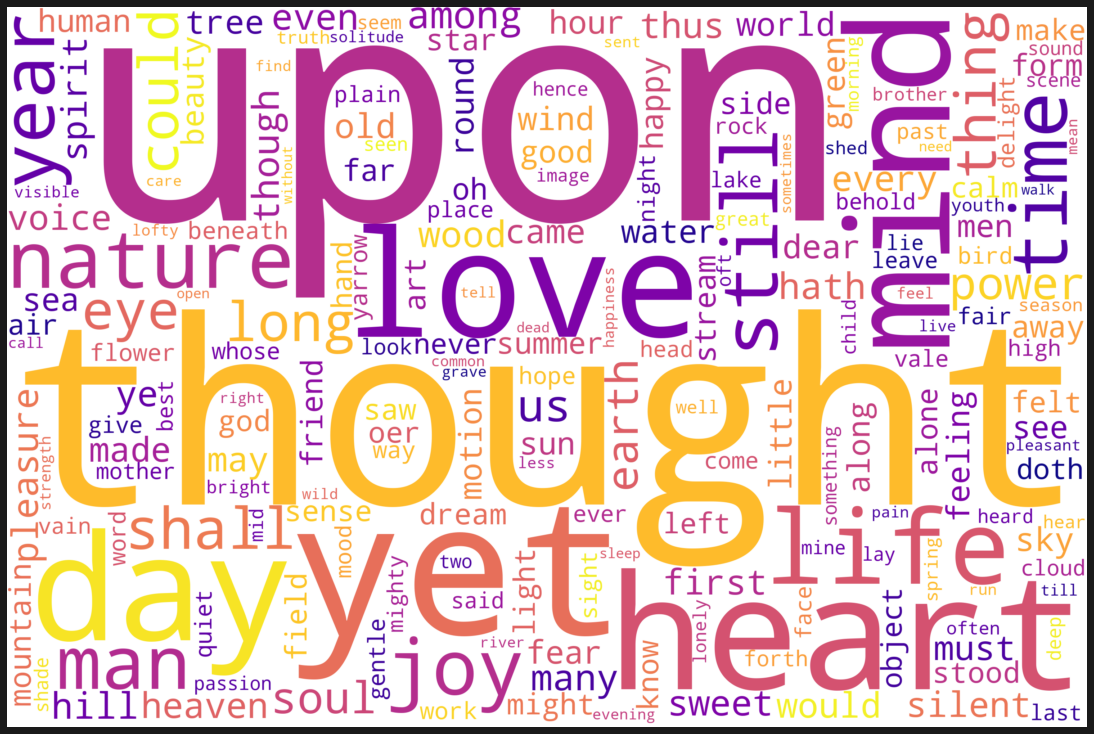

In [ ]:
name_poet = "William Wordsworth"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

#### Poet: Emily Dickinson

In [ ]:
name_poet= "Emily Dickinson"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

Emily Dickinson


#### Poet: Rae Armantrout

Rae Armantrout


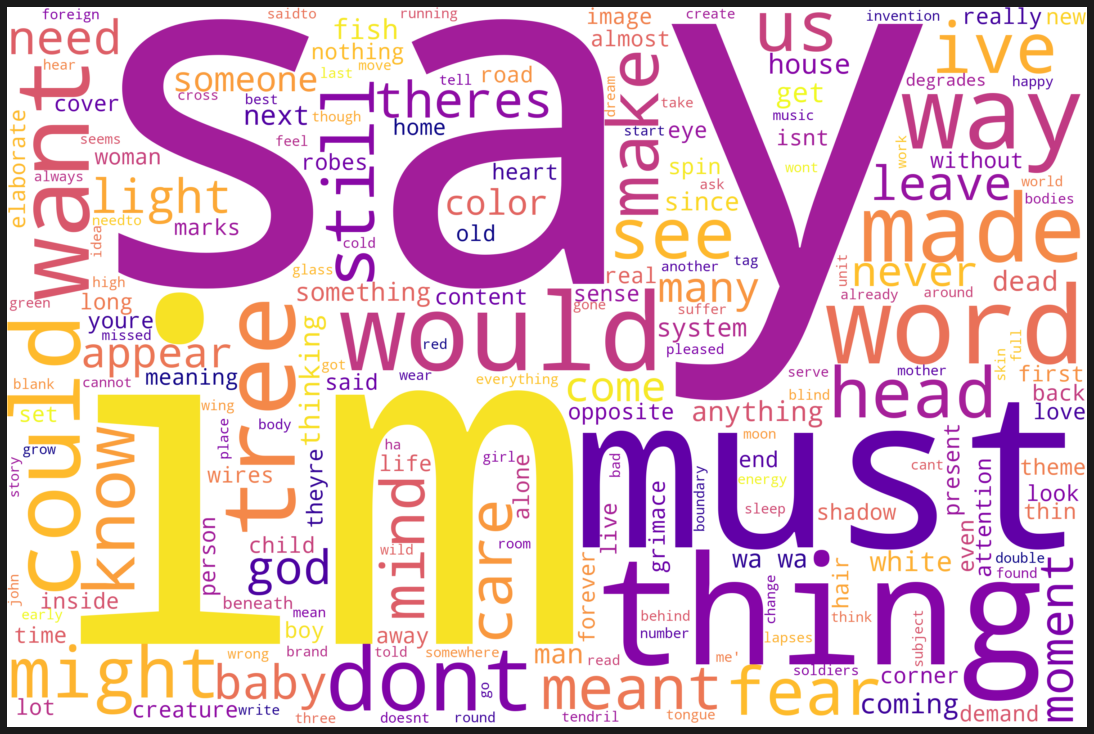

In [ ]:
name_poet = "Rae Armantrout"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

####Poet: Yusef Komunyakaa

In [ ]:
name_poet = "Yusef Komunyakaa"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

Yusef Komunyakaa


####Poet: John Ashbery

John Ashbery


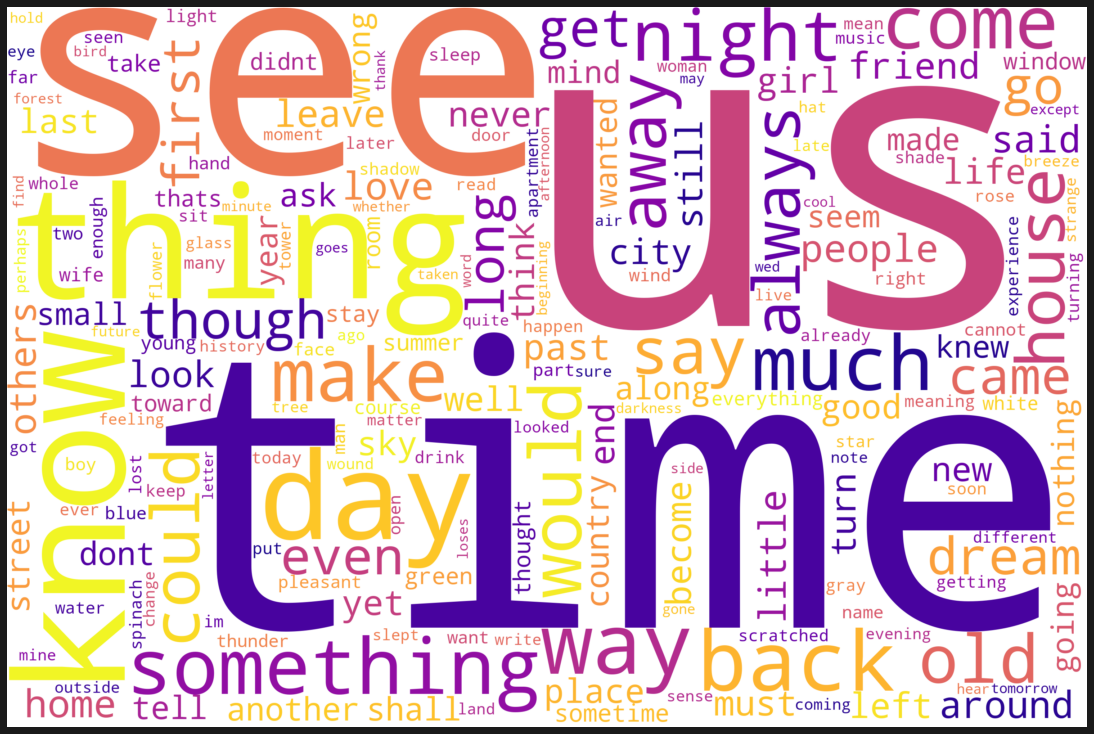

In [ ]:
name_poet = "John Ashbery"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

#### Poet: William Butler Yeats

William Butler Yeats


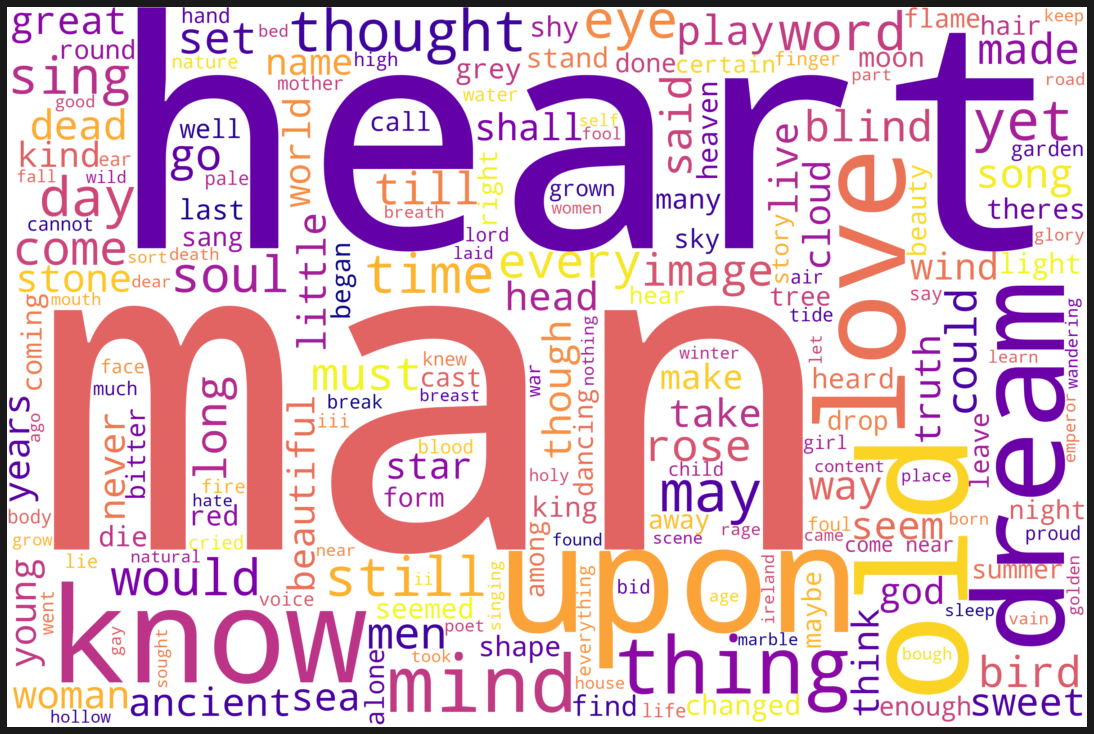

In [ ]:
name_poet = "William Butler Yeats"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

#### Poet: John Donne

John Donne


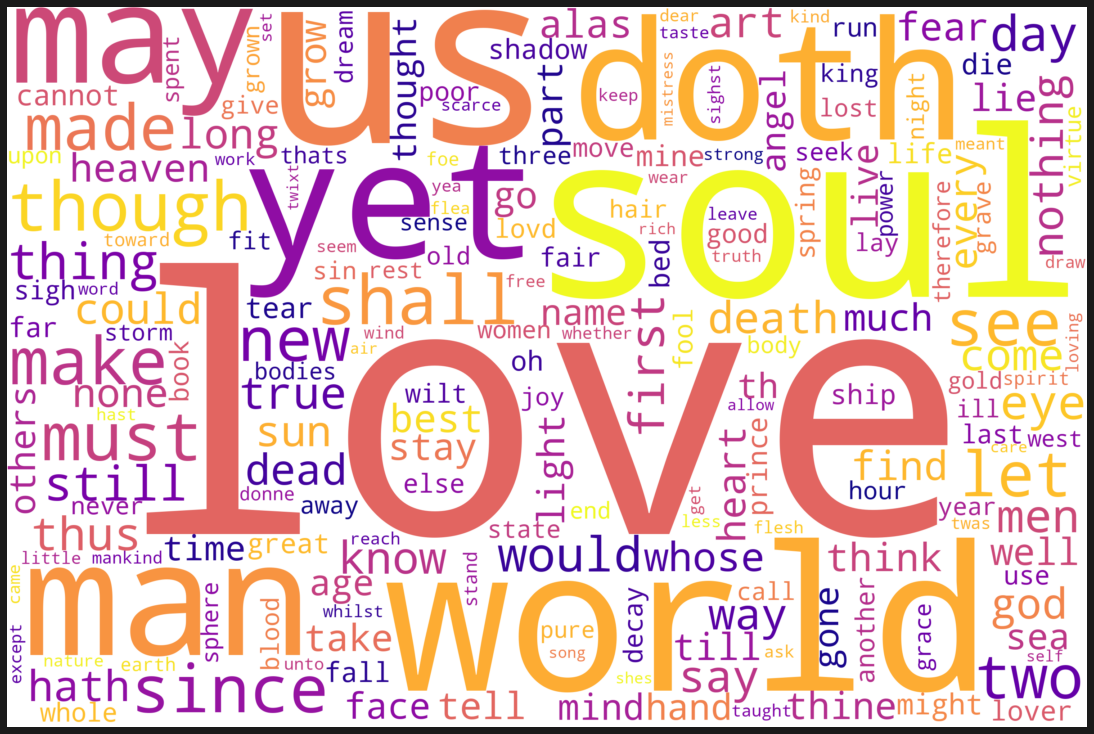

In [ ]:
name_poet = "John Donne"
plot_word_cloud(df = df_poems, name_poet_=name_poet)

#### Poet: Walt Whitman

Walt Whitman


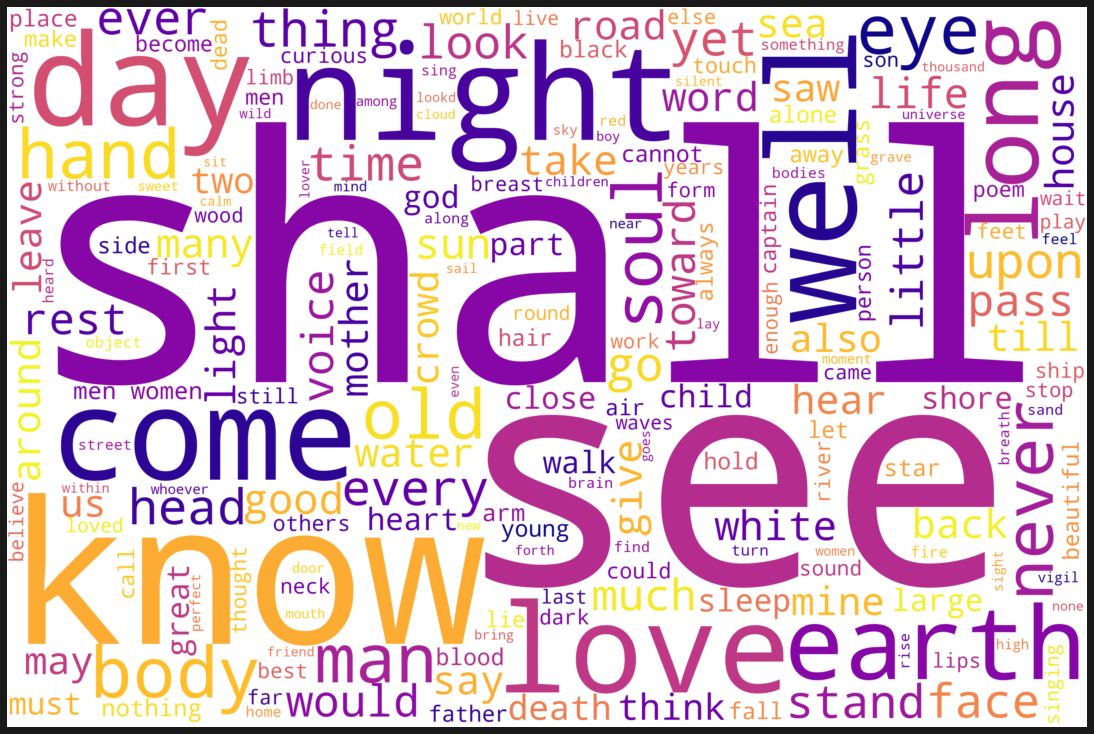

In [ ]:
name_poet = "Walt Whitman"
plot_word_cloud(df = df_poems, name_poet_=name_poet)